# Classification Task - Activity Recognition in Goats

<div class="alert alert-block alert-info">

## Table of Contents <a class="anchor" id="top"></a>
[1. Import Used Packages and Functions](#section_1)<br>
[2. Data Loading and Cleaning](#section_2)<br>
[3. Data Exploration](#section_3)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1 Feature Information](#section_3_1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.2 Feature Renaming and Dropping](#section_3_2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.3 *activity* and *animal_ID* Feature Visualisation](#section_3_3)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.4 Missing Data Visualisation](#section_3_4)<br>
[4. Data Pre-processing](#section_4)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.1 Train-Test Split Preparation](#section_4_1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.2 Train-Test Split](#section_4_2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.3 Missing Data Imputation](#section_4_3)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.4 Outlier Detection and Removal](#section_4_4)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.5 Novelty Detection and Removal](#section_4_5)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.6 Majority Undersampling](#section_4_6)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.7 Minority Oversampling](#section_4_7)<br>
[5. Data Fitting](#section_5)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[5.1 Support Vector Machine Classification](#section_5_1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[5.2 Random Forest Classification](#section_5_2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[5.3 Quadratic Discriminant Analysis Classification](#section_5_3)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[5.4 k-Nearest Neigbours Classification](#section_5_4)<br>
[6. Dimensionality Reduction](#section_6)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[6.1 Principal Component Analysis (Linear Feature Extraction, Unsupervised)](#section_6_1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[6.2 Linear Discriminant Analysis (Linear Feature Extraction, Supervised)](#section_6_2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[6.3 Locally Linear Embedding (Non-Linear Feature Extraction, Unspervised)](#section_6_3)<br>
</div>

<h2 style="display: inline"> 1. Import Used Packages and Functions </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_1"></a>

In [48]:
import pandas as pd

import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.metrics import f1_score, recall_score, precision_score, balanced_accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding

import seaborn as sns

import matplotlib.pyplot as plt

import missingno as msno

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import timeit

import warnings

from joblib import Memory

warnings.filterwarnings('ignore')

<h2 style="display: inline"> 2. Data Loading and Cleaning </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_2"></a>

The following piece of code creates a function that loads in the data and performs following transformations:
1. Loads in the data and prints the number of rows and columns.
2. Removes the empty columns (features) and prints the remaining number of rows and columns.
3. Standardizes the capitalization of text using Pandas vectorized string method *.str.lower()*.
4. Removes columns (features) with only one unique value (NaN's are ignored) and prints the remaing number of rows and columns.
5. Removes duplicate rows (instances) using the Pandas *.drop_duplicates* function.

In [2]:
def load_and_clean_data(file_path):
    
    # Load CSV file
    df = pd.read_csv(file_path, sep=',')
    print(f'The raw dataframe has {df.shape[0]} rows and {df.shape[1]} columns.')
    
    # Remove empty features (columns)
    df.dropna(axis=1, how='all', inplace=True)
    print(f'The dataframe after removing all empty features has {df.shape[0]} rows and {df.shape[1]} columns.')
    
    # Standardize capitalization of text using Pandas vectorized string method (i.e., they operate on entire arrays of data at once, and thus they are generally more efficient than methods that operate on one element at a time, like applymap)
    # e.g., df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
    df.loc[:, df.dtypes == 'object'] = df.select_dtypes(['object']).apply(lambda x: x.str.lower())
    
    # Remove features (columns) with only one unique value
    # NA values are not counted as a unique value so a column with only ones and NA should still be removed
    # In my opinion this is fair as, from a data perspective, we have no idea what other values could possibly be realistic to replace the NaN so using a multivariate imputer could result in unrealistic numbers. Imputing the missing values univariately would result in a column with all equal values, thus no information as there is no variance.
    df = df.loc[:, df.nunique() != 1]
    print(f'The dataframe after removing all empty and single-value features has {df.shape[0]} rows and {df.shape[1]} columns.')
    
    # Remove duplicate instances (rows)
    df.drop_duplicates(inplace = True)
    print(f'The dataframe after removing all empty and single-value features and all duplicate instances has {df.shape[0]} rows and {df.shape[1]} columns.')

    # Calculate the percentage of missing values based on the number of cells
    missing_values_total = df.isnull().sum().sum()
    values_total = np.prod(df.shape)
    missing_rate = missing_values_total  / values_total
    print(f'The percentage of missing values is equal to {missing_rate*100:.4f} with {missing_values_total} missing values on {values_total} values.')

    return df

The function is applied to the data and the execution speed is timed.

In [3]:
# dDtermine start time
start_time = timeit.default_timer()

# Specifiy file path
file_path = 'C:/Users/sande/OneDrive - UGent/big_data_science/project/goats.csv'

# Load and clean the data from the specified path
df = load_and_clean_data(file_path)

# Determine end time
end_time = timeit.default_timer()

# Calculate and print execution time
execution_time = end_time - start_time
print(f'Executed the code in: {execution_time:.4f} seconds')

The raw dataframe has 18994 rows and 154 columns.
The dataframe after removing all empty features has 18994 rows and 104 columns.
The dataframe after removing all empty and single-value features has 18994 rows and 87 columns.
The dataframe after removing all empty and single-value features and all duplicate instances has 18994 rows and 87 columns.
The percentage of missing values is equal to 6.4858 with 107176 missing values on 1652478 values.
Executed the code in: 0.2931 seconds


<h2 style="display: inline"> 3. Data Exploration </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_3"></a> 

<h2 style="display: inline"> 3.1 Feature Information </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_3_1"></a> 

Let us first look at the head of the dataframe using the *.head()* function. We can see that the target column is named *class* and that the *animal_ID* column can be important in data pre-processing.

In [4]:
df.head(n = 5)

,animal_ID,segment_ID,timestamp,a_vector_hurst,a_vector_unitroot_pp,a_vector_unitroot_kpss,a_vector_stability,a_vector_trend,a_vector_spike,a_vector_linearity,...,g_vector_arch_lm,g_vector_x_acf1,g_vector_x_acf10,g_vector_diff1_acf1,g_vector_diff1_acf10,g_vector_diff2_acf1,g_vector_diff2_acf10,pressure,temp,class
0,g1,100,642.001,0.521575,-28.938445,0.050414,0.840889,0.612804,0.000002,-0.004319,...,0.998948,0.989121,6.280122,0.919305,1.661123,0.808073,1.523806,1008.7450,33.31125,walking
1,g1,100,644.001,0.567764,-37.580618,0.047019,0.765626,0.526370,0.000008,-0.676192,...,0.984484,0.984651,5.308345,0.897672,1.627134,0.610443,0.639739,1008.7598,33.31720,walking
2,g1,101,648.001,0.534168,-35.544131,0.079115,0.789741,0.555126,0.000004,1.262893,...,0.984780,0.984139,5.261556,0.899458,1.735248,0.698002,1.069269,1008.7468,33.37425,walking
3,g1,102,652.001,0.513071,-35.836599,0.030903,0.769454,0.568718,0.000004,-0.383610,...,0.998334,0.980494,4.717197,0.926260,1.865898,0.800432,1.393809,1008.8148,34.11770,walking
4,g1,102,654.001,0.486342,-33.188392,0.038271,0.782253,0.554476,0.000002,0.075402,...,0.974447,0.979816,5.263391,0.886591,1.381983,0.636014,0.847309,1008.8226,34.11785,walking


In [5]:
df.tail(n = 5)

,animal_ID,segment_ID,timestamp,a_vector_hurst,a_vector_unitroot_pp,a_vector_unitroot_kpss,a_vector_stability,a_vector_trend,a_vector_spike,a_vector_linearity,...,g_vector_arch_lm,g_vector_x_acf1,g_vector_x_acf10,g_vector_diff1_acf1,g_vector_diff1_acf10,g_vector_diff2_acf1,g_vector_diff2_acf10,pressure,temp,class
18989,g4,98,674.001,0.546408,-28.985080,0.074632,0.823037,0.653534,0.000003,0.976432,...,0.992992,0.983577,4.910303,0.917898,1.945894,0.805903,1.825046,1008.9232,45.379600,walking
18990,g4,98,676.001,0.574063,-24.546896,0.070628,0.849638,0.718300,0.000002,1.225615,...,0.991389,0.982767,4.978059,0.900030,1.617334,0.753910,1.322444,1008.9010,45.375450,walking
18991,g4,99,680.001,0.658680,-30.016566,0.077178,0.792598,0.647381,0.000003,-0.554455,...,0.995453,0.981927,4.422025,0.927695,2.276061,0.804187,1.485858,1008.9480,45.304700,walking
18992,g4,9,62.001,0.563446,-40.322917,0.092269,0.793434,0.584016,0.000006,-1.137299,...,0.994158,0.983329,4.512319,0.917167,1.757347,0.718912,0.953544,1008.3290,41.097750,walking
18993,g4,9,64.001,0.483464,-53.611915,0.049455,0.607255,0.437178,0.000007,-0.452429,...,0.988995,0.977039,4.194452,0.771905,1.065190,0.309802,0.573943,1008.3654,41.091375,walking


<h2 style="display: inline"> 3.2 Feature Renaming and Dropping </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_3_2"></a>

Using the variable name *class* in python is not recommended, as *class* is a (reserved) keyword. Therefore we will change the variable name to *activity*.

In [6]:
# Rename 'class' to 'activity'
df.rename(columns = {'class': 'activity'}, inplace = True)

Let us also determine the unique values used in the *animal_ID* and *class* columns, this is usefull information to know for further data preprocessing.

In [7]:
# Determine the unique values in 'animal_ID' and 'activity'
df[['animal_ID', 'activity']].apply(pd.Series.unique)

animal_ID                                     [g1, g2, g3, g4]
activity     [walking, trotting, stationary, grazing, running]
dtype: object

Knowing about the metadata structure of the dataset, the *segment_ID* and *timestamp* features are not important as they do not provide predictive power (e.g., *timestamp* does not reflect the hour of the day, which could be important concidering the circeadian rythm of the goats behaviour. *segment_ID* also hold no predictive information).

In [8]:
# 'segment_ID' and 'timestamp' are dropped from the data frame
df.drop(columns = ['segment_ID', 'timestamp'], inplace = True)

<h2 style="display: inline"> 3.3 <em>class</em> and <em>animal_ID</em> Feature Visualisation </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_3_3"></a>

Before visualisation, the data is ordered.

In [9]:
# Sort the data by 'animal_ID' and 'activity'
# Note, this will change the index of the dataframe
df.sort_values(['animal_ID', 'activity'])

# Sort the columns alphabetically
df = df.sort_index(axis = 1)

Let us start by visualizing the data per class and per animal. This should give us an idea which classes are the largest and to what a degree each animal provides data to that class.

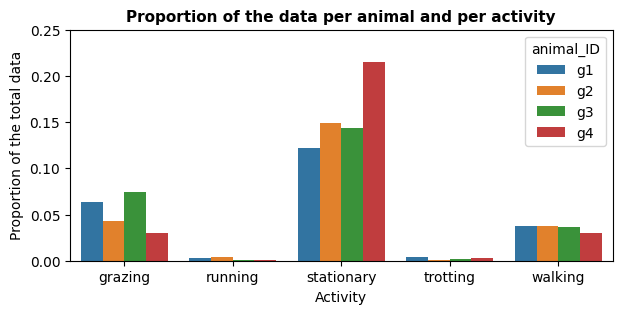

Executed the code in: 0.09831879998091608 seconds


In [10]:
# Determine start time
start_time = timeit.default_timer()

# Count instances for each 'activity' and 'animal_ID'
df_counts = df.groupby(['activity', 'animal_ID']).size().reset_index(name = 'counts')

# Calculate cumulative counts with group_keys=False
df_counts['counts'] = df_counts.groupby(['activity','animal_ID'], group_keys = False)['counts'].apply(lambda x: x.cumsum())

# Normalizing counts by dividing by the total number of instances
df_counts_total = df_counts['counts'].sum()
df_counts['proportion'] = df_counts['counts'] / df_counts_total

# Creating and plotting the cumulative bar plot
plt.figure(figsize = (7, 3))
sns.barplot(x = 'activity', y = 'proportion', hue = 'animal_ID', data = df_counts, errorbar = None)

# Display the plot
plt.ylim(0, 0.25)
plt.title('Proportion of the data per animal and per activity', fontsize = 11, fontweight = 'bold')
plt.xlabel('Activity')
plt.ylabel('Proportion of the total data')
plt.show()

# Determine end time
end_time = timeit.default_timer()

# Calculate and print execution time
execution_time = end_time - start_time
print(f'Executed the code in: {execution_time} seconds')

It is clear from the plot that, on average, there is no goat that dominates the data of a particular acitivity class. What is clear however is that the *running* and *trotting* activity classes are very data sparse. Therefore, it may be worth to oversample those two classes or undersample the *grazing*, *stationary* and *walking* class to create a more fair train and test dataset.

<h2 style="display: inline"> 3.4 Missing Data Visualisation </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_3_4"></a>

By generating a missing value heat map, we can already get an idea about the distribution of missing data in the data set.
We will not yet impute missing data, this is just to get a sense of where the missing data is located.

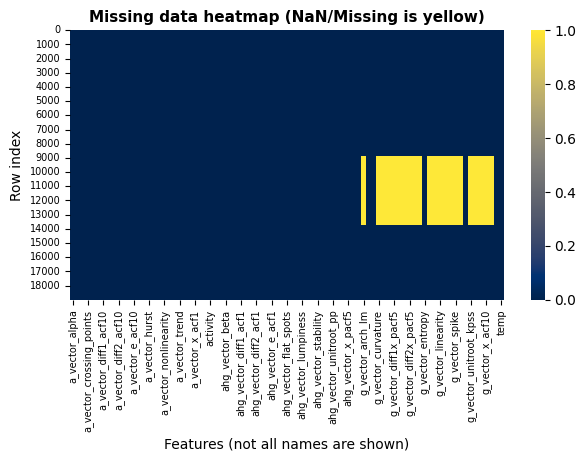

In [11]:
# Generate a heatmap of missing values
plt.figure(figsize = (7, 3.5))
sns.heatmap(df.isnull(), cmap = 'cividis')

# Display the plot
plt.title('Missing data heatmap (NaN/Missing is yellow)', fontsize = 11, fontweight = 'bold')
plt.xlabel('Features (not all names are shown)', fontsize = 10)
plt.ylabel('Row index', fontsize = 10)
plt.xticks(fontsize = 7)
plt.yticks(fontsize = 7)
plt.show()

Knowing that we have ordered the data according to *animal_ID* and following by *activity*, it seems that a specific animal and/or activity has a lot of missing values. Let us therefore calculate the proportion of missing data per goat and per activity.

In [12]:
# Calculate the percentage of missing values for each goat in 'animal_ID'
missing_values_by_animal = df.groupby('animal_ID').apply(lambda x: x.isnull().sum().sum())
total_cells_by_animal = df.groupby('animal_ID').size() * (df.shape[1])
missing_rate_by_animal = missing_values_by_animal / total_cells_by_animal

# Print the results for each goat
for animal_id, missing_rate in zip(missing_values_by_animal.index, missing_rate_by_animal):
    print(f"Animal ID: {animal_id} - Missing Rate: {missing_rate*100:.4f}%")

Animal ID: g1 - Missing Rate: 0.0003%
Animal ID: g2 - Missing Rate: 0.0013%
Animal ID: g3 - Missing Rate: 25.8824%
Animal ID: g4 - Missing Rate: 0.0018%


In [13]:
# Calculate the percentage of missing values for each activity in 'activity'
missing_values_by_class = df.groupby('activity').apply(lambda x: x.isnull().sum().sum())
total_cells_by_class = df.groupby('activity').size() * (df.shape[1])
missing_rate_by_class = missing_values_by_class / total_cells_by_class

# Print the results for each activity
for activity, missing_rate in zip(missing_values_by_class.index, missing_rate_by_class):
    print(f"Activity: {activity} - Missing Rate: {missing_rate*100:.4f}%")

Activity: grazing - Missing Rate: 9.1201%
Activity: running - Missing Rate: 1.5634%
Activity: stationary - Missing Rate: 5.9010%
Activity: trotting - Missing Rate: 5.1196%
Activity: walking - Missing Rate: 6.6031%


It is clear that the main source of missing data comes from goat 3, we can have a deeper dive into which features are responsible for this missing data.
For this we use the package *missingno*.

<Axes: >

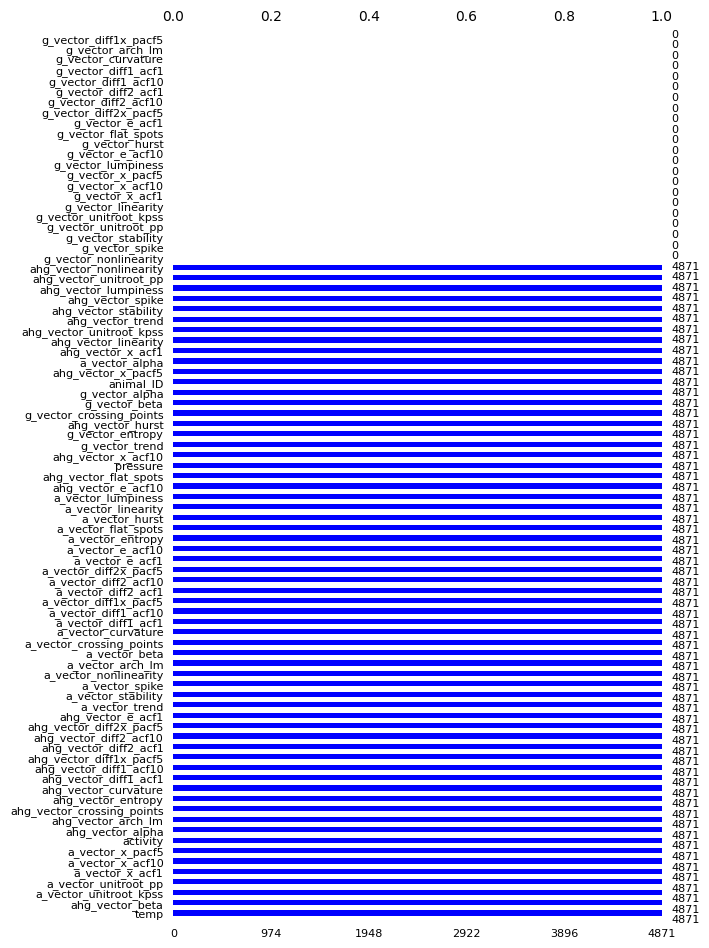

In [14]:
# Plot the number of rows containing a missing value for 'animal_ID'=='g3' for each feature
msno.bar(df[df['animal_ID'] == 'g3'], figsize=(6.3, 11.5), fontsize = 8, color = "blue", sort = "descending")

The high amount of missing data suggests that it is Missing At Random (MAR) or Missing Not At Random (MNAR). Using the bar() function of the missingno package, we can see that the main features responsible for the missing data for goat three start with g_..., indicating the values have to do with the 3D gyroscope sensor that is part of the measuring equipment. This could indicate a faulty/broken 3D gyroscope and thus that the missing data are MNAR (the probability of data being missing depends on the unobserved data, conditional on the observed data OR the probability of a missing value depends on the variable that is missing), conditional on the animal_ID, g3, and dependent on unobserved data, i.e., the variable is_the_sensor_functioning_or_not. The problem is that, in this case, complete case analysis may be highly biased, bias resolution may be impossible, and MNAR data needs external info for a realistic imputation model or sensitivity analysis (outside the project’s scope). Prof. Goetghebeur additionally specified in her guest lecture that: *“The data can tell you whether MAR rather than MCAR holds. Nothing beyond.”*

Therefore, the following is proposed: imputation of this missing data is possible based on the observed values for goats 1, 2 and 4, but it would essentially mean that all the values for goat 3 will be based on the behaviour of goats 1, 2, and 3. For simplicities sake, the assumption will be made that the movement of goats in the different activities will be considered similar across different goats, i.e., the movements performed by goat 1 while grazing will be very similar to the movements performed by goat 3 while grazing and so on for the different activities. To this end, the goat’s identity is no longer important and will be dropped. An additional reason for performing this data transformation is that we want to create a model that can predict the behaviour of a random future goat, e.g., goat 5.

<h2 style="display: inline"> 4. Data Pre-processing </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_4"></a> 

<h2 style="display: inline"> 4.1 Train-Test Split Preparation </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_4_1"></a> 

For any given activity class, no goat is dominant and because we would like a classifier that is goat independent, We would propose to drop the *animal_ID* feature from the dataset.

In [15]:
# Drop the 'animal_ID' feature
df.drop(columns = ['animal_ID'], inplace = True)

Before generating the training and test dataset, let us first prepare the data by splitting the dataframe in its X and y part. Next, the y target values are encoded using the *LabelEncoder()* function.

In [16]:
# Determine start time
start_time = timeit.default_timer()

# Separate predictor values from target values by selecting the target feature
target_col = ['activity']

# generate X and y datasets, are pandas Dataframes, therefore the suffix _pddf (pandasdataframe)
X_pddf = df.drop(columns = target_col)
y_pddf = df[target_col]

# Store the column names before the transformations
X_column_names = X_pddf.columns
y_column_name = y_pddf.columns

# Convert X and y to numpy arrays, from now on we work with numpy arrays, by saving the column names, we can later recreate the pandas Dataframes if necessary
X = X_pddf.values
y = y_pddf.values.ravel() # flatten the 2D numpy array to a 1D numpy array

# Encode target values and return the encoded target
encoder_y = LabelEncoder()
y_encoded = encoder_y.fit_transform(y)

# Determine end time
end_time = timeit.default_timer()

# Calculate and print execution time
execution_time = end_time - start_time
print(f'Executed the code in: {execution_time} seconds')

Executed the code in: 0.005898399977013469 seconds


Are there categorical variables in X? This will be the case if the code below results in a value > 0.

In [17]:
X_categorical_features = X_pddf.select_dtypes(include = ['object']).columns
X_categorical_features.size

0

It does not, so no further categorisation of features in X is necessary. Just as a note, this could be achieved using (written in Markdown block):

ohe_transformer = make_column_transformer(
        (OneHotEncoder(), X_categorical_features), remainder='passthrough'
    )

ohe_transformed = ohe_transformer.fit_transform(X)
X_encoded = pd.DataFrame(
        ohe_transformed,
        columns=ohe_transformer.get_feature_names_out()
    )

<h2 style="display: inline"> 4.2 Train-Test Split </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_4_2"></a>

The dataset is now split in the predictor data set *X* and the target one-dimensional encoded data set *y*. The data is now ready to be split in a training and test set, stratified on the *activity*.

In [18]:
# Determine start time
start_time = timeit.default_timer()

# Perform the train test split using the train_test_split() function
X_train, X_test, y_encoded_train, y_encoded_test = train_test_split(X, y_encoded, test_size = 0.2, random_state = 0, stratify = y_encoded)

# Determine end time
end_time = timeit.default_timer()

# Calculate and print execution time
execution_time = end_time - start_time
print(f'Executed the code in: {execution_time} seconds')

Executed the code in: 0.007146599993575364 seconds


<h2 style="display: inline"> 4.3 Missing Data Imputation </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_4_3"></a> 

The multivariate k-NN imputer is used to impute missing values.

In [20]:
# Determine start time
start_time = timeit.default_timer()

# Call the KNNImputer function
kNN_imputer = KNNImputer(n_neighbors = 5, weights = 'uniform', add_indicator = False)

# Fit the KNNImputer function to the training data
kNN_imputer.fit(X_train)

# Transform the training and test sets using the fitted KNNImputer
X_train_imp = kNN_imputer.transform(X_train)
X_test_imp = kNN_imputer.transform(X_test)

# Determine end time
end_time = timeit.default_timer()

# Calculate and print execution time
execution_time = end_time - start_time
print(f'Executed the code in: {execution_time} seconds')

Executed the code in: 19.84034920000704 seconds


<h2 style="display: inline"> 4.4 Outlier Detection and Removal </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_4_4"></a> 

Local Outlier Factor (LOF) is chosen for outlier/novelty detection and removal for several reasons:
1. **Local Sensitivity**: LOF is sensitive to local anomalies as opposed to global ones. This means it is effective in identifying outliers that may not appear as outliers when considering the whole data set but are outliers in their local neighborhood.

2. **High Dimensional Data**: LOF is effective in high-dimensional spaces.

3. **No Assumption about the Distribution**: LOF does not make any assumptions about the distribution of the data.

4. **Density-based Method**: LOF is a density-based method which means it's suitable for datasets where the density varies, which is very interesting in out imbalanced classification problem.

5. **Novelty Detection**: The `novelty` parameter is set to `True`, so it can be used for novelty detection. This allows the model to be used on the test data to detect whether it contains outliers.

In [21]:
# Call the LOG function with novelty=False
lof_outlier = LocalOutlierFactor(n_neighbors = 20, n_jobs = -1, novelty = False)

# Fit the LFO to the imputed training data (containing to NaN's) and predict the in- and outliers in the training set
X_train_imp_lof = lof_outlier.fit_predict(X_train_imp)

# Identify inliers in the training set
mask_train = X_train_imp_lof == 1

# Filter the training set to keep only the inliers
X_train_imp_inliers = X_train_imp[mask_train]
y_encoded_train_inliers = y_encoded_train[mask_train]

# Print the change in the number of instances in the training set
print(f'The training data set after missing value imputing and before outlier removel has {X_train_imp.shape[0]} rows.')
print(f'The training data set after missing value imputing and after outlier removel has {X_train_imp_inliers.shape[0]} rows.')

The training data set after missing value imputing and before outlier removel has 15195 rows.
The training data set after missing value imputing and after outlier removel has 15029 rows.


<h2 style="display: inline"> 4.5 Novelty Detection and Removal </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_4_5"></a> 

By setting the `novelty` to `True`, the LOF function can be used for novelty detection. According to the sklearn documentation (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html): *In this case be aware that you should only use predict, decision_function and score_samples on new unseen data and not on the training set; and note that the results obtained this way may differ from the standard LOF results.*

In [22]:
# Call the LOF function with novelty=True
lof_novelty = LocalOutlierFactor(n_neighbors = 20, n_jobs = -1, novelty = True)

# Fit the LFO to the imputed training data (containing to NaN's)
lof_novelty.fit(X_train_imp)

# Predict the in- and outliers in the test set
X_test_imp_lof_novelty = lof_novelty.predict(X_test_imp)

# Identify inliers in the test set
mask_test = X_test_imp_lof_novelty == 1

# Filter the test set to keep only inliers
X_test_imp_inliers = X_test_imp[mask_test]
y_encoded_test_inliers = y_encoded_test[mask_test]

# Print the change in the number of instances in the test set
print(f'The test data set after missing value imputing and before outlier removel has {X_test_imp.shape[0]} rows.')
print(f'The test data set after missing value imputing and after outlier removel has {X_test_imp_inliers.shape[0]} rows.')

The test data set after missing value imputing and before outlier removel has 3799 rows.
The test data set after missing value imputing and after outlier removel has 3759 rows.


<h2 style="display: inline"> 4.6 Majority Undersampling </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_4_6"></a> 

Do to the imbalance in the classes, a resampling technique is recommended to balance the classes. For weaker hardware undersampling of the majority class will reduce the training set size for faster model hyperparameter optimization, training and testing.

`RandomUnderSampling()` will be chosen for its simplicity in use and understandability, it is part of the `imbalanced-learn` package.

In [23]:
# Under-sample the majority classes in the training set
rus = RandomUnderSampler(sampling_strategy = 'not minority', random_state = 0)
X_train_imp_inliers_undrsmpl, y_encoded_train_inliers_undrsmpl = rus.fit_resample(X_train_imp_inliers, y_encoded_train_inliers)

print(f'The train data set after imputing and outlier removel and before RUS has {X_train_imp_inliers.shape[0]} rows.')
print(f'The train data set after imputing and outlier removel and after RUS has {X_train_imp_inliers_undrsmpl.shape[0]} rows.')

The train data set after imputing and outlier removel and before RUS has 15029 rows.
The train data set after imputing and outlier removel and after RUS has 575 rows.


The RUS technique will also be visualised.

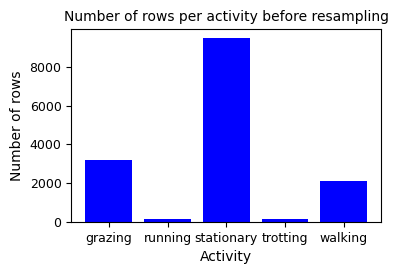

In [24]:
# Recode the activity classes for visualisation
y_train_inliers = encoder_y.inverse_transform(y_encoded_train_inliers)

# Find unique classes and their counts
classes, counts = np.unique(y_train_inliers, return_counts = True)

# Plotting
plt.figure(figsize = (4, 2.5))
plt.bar(classes, counts, color = 'blue')
plt.xlabel('Activity', fontsize = 10)
plt.ylabel('Number of rows', fontsize = 10)
plt.title('Number of rows per activity before resampling', fontsize = 10)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
plt.show()

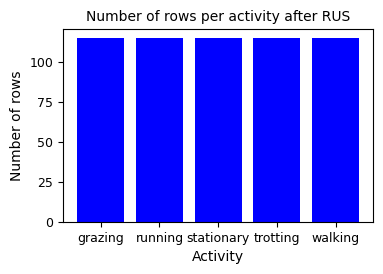

In [25]:
# Recode the activity classes for visualisation
y_train_inliers_undrsmpl = encoder_y.inverse_transform(y_encoded_train_inliers_undrsmpl)

# Find unique classes and their counts
classes, counts = np.unique(y_train_inliers_undrsmpl, return_counts = True)

# Plotting
plt.figure(figsize = (4, 2.5))
plt.bar(classes, counts, color = 'blue')
plt.xlabel('Activity', fontsize = 10)
plt.ylabel('Number of rows', fontsize = 10)
plt.title('Number of rows per activity after RUS', fontsize = 10)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
plt.show()

<h2 style="display: inline"> 4.7 Minority Oversampling </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_4_7"></a> 

On more powerfull hardware, minority oversampling can be explored to synthetically generate more minority class instances. A popular technique is SMOTE (Synthetic Minority Over-sampling TEchnique), an implimentation is also part of the `imbalanced-learn` package.

In [26]:
# Synthetically over-sample the minority classes in the training set
smote = SMOTE(random_state = 0, n_jobs = -1)
X_train_imp_inliers_ovrsmpl, y_encoded_train_inliers_ovrsmpl = smote.fit_resample(X_train_imp_inliers, y_encoded_train_inliers)

print(f'The train dataset after imputing and outlier removel and before resampling has {X_train_imp_inliers.shape[0]} rows.')
print(f'The train dataset after imputing and outlier removel and after resampling has {X_train_imp_inliers_ovrsmpl.shape[0]} rows.')

The train dataset after imputing and outlier removel and before resampling has 15029 rows.
The train dataset after imputing and outlier removel and after resampling has 47350 rows.


This over-sampling will is also visualised.

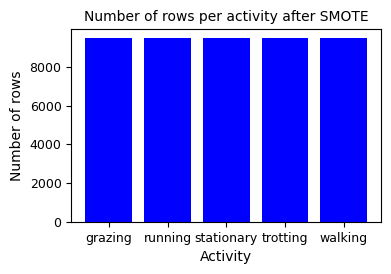

In [27]:
# Recode the activity classes for visualisation
y_train_inliers_ovrsmpl = encoder_y.inverse_transform(y_encoded_train_inliers_ovrsmpl)

# Find unique classes and their counts
classes, counts = np.unique(y_train_inliers_ovrsmpl, return_counts = True)

# Plotting
plt.figure(figsize = (4, 2.5))
plt.bar(classes, counts, color = 'blue')
plt.xlabel('Activity', fontsize = 10)
plt.ylabel('Number of rows', fontsize = 10)
plt.title('Number of rows per activity after SMOTE', fontsize = 10)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
plt.show()

<h2 style="display: inline"> 5. Data Fitting </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_5"></a>

After pre-preprocessing the data, model fitting can be explored. Hyperparameter optimization and model evaluation are combined using a nested cross-validation approach. The `StratifiedKFold` function will be utilized to set up a 5-fold stratified outer cross-validation for model evaluation (80-20 train-test split) and a 4-fold stratified inner cross-validation for hyperparameter optimization (75-25 train-test split).

In [28]:
# Choose cross-validation techniques for the inner and outer loops, independently of the dataset.
# StratifiedKFold is selected
inner_cv = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 0)
outer_cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
scoring_list = ['balanced_accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

<h2 style="display: inline"> 5.1 Support Vector Machine Classification </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_5_1"></a> 

In [27]:
# Determine start time
start_time = timeit.default_timer()

# Create a Memory object
memory_obj = Memory('C:/cachedir/', verbose = 0)

# Create the pipeline: scaler and classifier
# We will use a Support Vector Classifier
svc_pipeline = Pipeline(
    steps = [
        ('scaler', StandardScaler()),
        ('classifier', SVC())
        ],
    memory = memory_obj,
    verbose = True
    )

# Set up possible values of parameters to optimize over
svc_p_dist = {
          'scaler': [MinMaxScaler(), StandardScaler(), MaxAbsScaler(), QuantileTransformer(output_distribution = 'normal'), QuantileTransformer(output_distribution = 'uniform')],
          'classifier__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
          'classifier__decision_function_shape': ['ovo', 'ovr'],
          'classifier__C': [0.01, 0.1, 1, 10, 100],
          'classifier__gamma': ['scale', 'auto'],
          'classifier__degree': [2, 3, 4],
          'classifier__shrinking': [True, False]
          }

svc_clf = RandomizedSearchCV(estimator = svc_pipeline,
                         param_distributions = svc_p_dist,
                         cv = inner_cv,
                         n_iter = 30,
                         n_jobs = -1,
                         verbose = 3,
                         scoring = scoring_list,
                         refit = 'balanced_accuracy')

# Run cross validation to get the scores for each metric
svc_nested_score = cross_validate(svc_clf, X = X_train_imp_inliers_ovrsmpl, y = y_encoded_train_inliers_ovrsmpl, cv = outer_cv, scoring = scoring_list, return_estimator = True)

# Print the best parameters for each fold of the outer cross-validation loop
for i, estimator in enumerate(svc_nested_score['estimator']):
    print(f"Best parameters for fold {i}: {estimator.best_params_}")

# Print the best score for each fold of the outer cross-validation loop
for i, estimator in enumerate(svc_nested_score['estimator']):
    print(f"Best score for fold {i}: {estimator.best_score_:.4f}")

# Clear the cache
memory_obj.clear()

# Determine end time
end_time = timeit.default_timer()

# Calculate and print execution time
execution_time = end_time - start_time
print(f'Nested cross-validation was perfomed in {execution_time:.4f} seconds')

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.5s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   2.5s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   2.8s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   2.8s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   2.4s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classi

Best parameters for fold 0: {'scaler': QuantileTransformer(output_distribution='normal'), 'classifier__shrinking': True, 'classifier__kernel': 'rbf', 'classifier__gamma': 'auto', 'classifier__degree': 3, 'classifier__decision_function_shape': 'ovr', 'classifier__C': 10}
Best parameters for fold 1: {'scaler': QuantileTransformer(), 'classifier__shrinking': False, 'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__degree': 2, 'classifier__decision_function_shape': 'ovo', 'classifier__C': 100}
Best parameters for fold 2: {'scaler': QuantileTransformer(), 'classifier__shrinking': False, 'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__degree': 2, 'classifier__decision_function_shape': 'ovr', 'classifier__C': 100}
Best parameters for fold 3: {'scaler': StandardScaler(), 'classifier__shrinking': True, 'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__degree': 3, 'classifier__decision_function_shape': 'ovo', 'classifier__C': 10

In [52]:
# Determine start time
start_time = timeit.default_timer()

# Let us score the median/mode of the best parameters, train on training data and score on test data

# Fit the scaler on the training data
svc_scaler = QuantileTransformer(output_distribution = 'uniform')
svc_scaler.fit(X_train_imp_inliers_ovrsmpl)
# Scale the training set
X_train_imp_inliers_ovrsmpl_svc_scaled = svc_scaler.transform(X_train_imp_inliers_ovrsmpl)
# Scale the test dataset
X_test_imp_inliers_svc_scaled = svc_scaler.transform(X_test_imp_inliers)

# Declare the SVC model
svc = SVC(
    kernel = 'rbf',
    #degree = 3,
    gamma = 'scale',
    decision_function_shape = 'ovo',
    C = 100,
    shrinking = False,
    verbose = True,
    random_state=0
    )

# Fit the model to the full training set
svc.fit(X_train_imp_inliers_ovrsmpl_svc_scaled, y_encoded_train_inliers_ovrsmpl)

# Determine end time
end_time = timeit.default_timer()

# Calculate and print execution time
execution_time = end_time - start_time
print(f'The model was trained in {execution_time:.4f} seconds')

# Make predictions on the scaled test set
y_pred_svc = svc.predict(X_test_imp_inliers_svc_scaled)

# Compute different scoring metrics
# 'weighted' accounts for class imbalance
svc_f1 = f1_score(y_encoded_test_inliers, y_pred_svc, average = 'weighted')
svc_recall = recall_score(y_encoded_test_inliers, y_pred_svc, average = 'weighted')
svc_accuracy = balanced_accuracy_score(y_encoded_test_inliers, y_pred_svc)
svc_precision = precision_score(y_encoded_test_inliers, y_pred_svc, average = 'weighted')

print('Test set F1 score:', svc_f1)
print('Test set Recall score:', svc_recall)
print('Test set Accuracy score:', svc_accuracy)
print('Test set Precision score:', svc_precision)

[LibSVM]The model was trained in 4.7656 seconds
Test set F1 score: 0.9464777008813162
Test set Recall score: 0.9465283320031923
Test set Accuracy score: 0.9082454950213746
Test set Precision score: 0.9464782929484717


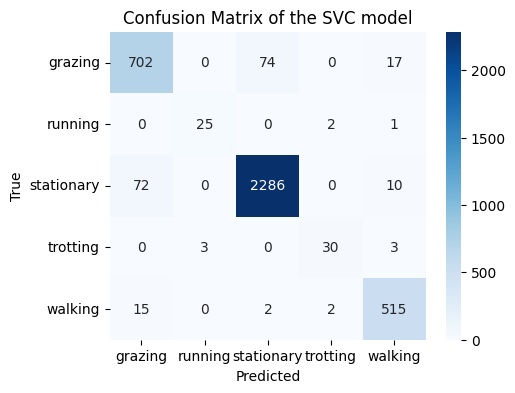

In [53]:
# Compute confusion matrix
svc_cm = confusion_matrix(y_encoded_test_inliers, y_pred_svc)

# Decode labels
class_names_svc = encoder_y.inverse_transform(list(range(svc_cm.shape[0])))

# Visualise the confusion matrix
plt.figure(figsize = (5.1, 4))
sns.heatmap(svc_cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names_svc, yticklabels = class_names_svc)
plt.title('Confusion Matrix of the SVC model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<h2 style="display: inline"> 5.2 Random Forest Classification </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_5_2"></a> 

In [39]:
# Determine start time
start_time = timeit.default_timer()

# Create a Memory object
memory_obj = Memory('C:/cachedir/', verbose = 0)

# Create the pipeline: classifier
# We will use a Random Forest Classifier
rfc_pipeline = Pipeline(
    steps = [
        ('classifier', RandomForestClassifier())
        ],
    memory = memory_obj,
    verbose = True
    )

# Set up possible values of parameters to optimize over
rfc_p_dist = {
        'classifier__n_estimators': [10, 50, 100, 200],
        'classifier__max_depth': [5, 10, 20],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [2, 5, 10],
        'classifier__bootstrap': [True, False]
        }

rfc_clf = RandomizedSearchCV(estimator = rfc_pipeline,
                         param_distributions = rfc_p_dist,
                         cv = inner_cv,
                         n_iter = 30,
                         n_jobs = -1,
                         verbose = 3,
                         scoring = scoring_list,
                         refit = 'balanced_accuracy')

# Run cross validation to get the scores for each metric
rfc_nested_score = cross_validate(rfc_clf, X = X_train_imp_inliers_ovrsmpl, y = y_encoded_train_inliers_ovrsmpl, cv = outer_cv, scoring = scoring_list, return_estimator = True)

# Print the best parameters for each fold of the outer cross-validation loop
for i, estimator in enumerate(rfc_nested_score['estimator']):
    print(f"Best parameters for fold {i}: {estimator.best_params_}")

# Print the best score for each fold of the outer cross-validation loop
for i, estimator in enumerate(rfc_nested_score['estimator']):
    print(f"Best score for fold {i}: {estimator.best_score_:.4f}")

# Clear the cache
memory_obj.clear()

# Determine end time
end_time = timeit.default_timer()

# Calculate and print execution time
execution_time = end_time - start_time
print(f'Executed the code in: {execution_time:.4f} seconds')

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ........ (step 1 of 1) Processing classifier, total=  33.6s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ........ (step 1 of 1) Processing classifier, total= 1.1min
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ........ (step 1 of 1) Processing classifier, total=   3.4s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ........ (step 1 of 1) Processing classifier, total=  50.5s
Fitting 4 folds for each of 30 candidates, totalling 120 fits


[Pipeline] ........ (step 1 of 1) Processing classifier, total= 1.1min
Best parameters for fold 0: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 20, 'classifier__bootstrap': False}
Best parameters for fold 1: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 5, 'classifier__max_depth': 20, 'classifier__bootstrap': False}
Best parameters for fold 2: {'classifier__n_estimators': 10, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 20, 'classifier__bootstrap': False}
Best parameters for fold 3: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 20, 'classifier__bootstrap': True}
Best parameters for fold 4: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_dep

In [51]:
# Determine start time
start_time = timeit.default_timer()

# Let us score the median/mode of the best parameters

# Declare the RFC model
rfc = RandomForestClassifier(
    n_estimators = 200,
    min_samples_split = 5,
    min_samples_leaf = 2,
    max_depth = 20,
    bootstrap = False,
    random_state=0
    )

# Fit the model to the full training set
rfc.fit(X_train_imp_inliers_ovrsmpl, y_encoded_train_inliers_ovrsmpl)

# Determine end time
end_time = timeit.default_timer()

# Calculate and print execution time
execution_time = end_time - start_time
print(f'The model was trained in {execution_time:.4f} seconds')

# Make predictions on the test set
y_pred_rfc = rfc.predict(X_test_imp_inliers)

# Compute different scoring metrics
# 'weighted' accounts for class imbalance
rfc_f1 = f1_score(y_encoded_test_inliers, y_pred_rfc, average = 'weighted')
rfc_recall = recall_score(y_encoded_test_inliers, y_pred_rfc, average = 'weighted')
rfc_accuracy = balanced_accuracy_score(y_encoded_test_inliers, y_pred_rfc)
rfc_precision = precision_score(y_encoded_test_inliers, y_pred_rfc, average = 'weighted')

print('Test set F1 score:', rfc_f1)
print('Test set Recall score:', rfc_recall)
print('Test set Accuracy score:', rfc_accuracy)
print('Test set Precision score:', rfc_precision)

The model was trained in 88.0346 seconds
Test set F1 score: 0.9437457500316115
Test set Recall score: 0.9430699654163341
Test set Accuracy score: 0.908135794985353
Test set Precision score: 0.9451441602269359


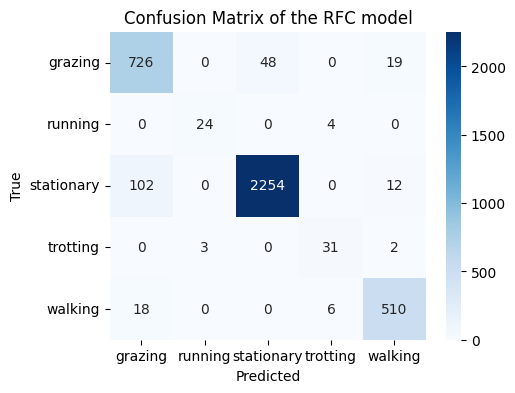

In [54]:
# Compute confusion matrix
rfc_cm = confusion_matrix(y_encoded_test_inliers, y_pred_rfc)

# Decode labels
class_names_rfc = encoder_y.inverse_transform(list(range(rfc_cm.shape[0])))

# Visualise the confusion matrix
plt.figure(figsize = (5.1, 4))
sns.heatmap(rfc_cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names_rfc, yticklabels = class_names_rfc)
plt.title('Confusion Matrix of the RFC model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<h2 style="display: inline"> 5.3 Quadratic Discriminant Analysis Classification </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_5_3"></a> 

In [44]:
# Determine start time
start_time = timeit.default_timer()

# Create a Memory object
memory_obj = Memory('C:/cachedir/', verbose = 0)

# Create the pipeline: scaler and classifier
# We will use a QDA Classifier
qda_pipeline = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('classifier', QuadraticDiscriminantAnalysis(store_covariance = True))
        ],
    memory=memory_obj,
    verbose=True
    )

# Set up possible values of parameters to optimize over
qda_p_dist = {
        'scaler': [MinMaxScaler(), StandardScaler(), MaxAbsScaler(), QuantileTransformer(output_distribution = 'normal'), QuantileTransformer(output_distribution = 'uniform')],
        'classifier__reg_param': [0, 0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.30]
          }

qda_clf = RandomizedSearchCV(estimator = qda_pipeline,
                         param_distributions = qda_p_dist,
                         cv = inner_cv,
                         n_iter = 30,
                         n_jobs = -1,
                         verbose = 3,
                         scoring = scoring_list,
                         refit = 'balanced_accuracy')

# Run cross validation to get the scores for each metric
qda_nested_score = cross_validate(qda_clf, X = X_train_imp_inliers_ovrsmpl, y = y_encoded_train_inliers_ovrsmpl, cv = outer_cv, scoring = scoring_list, return_estimator = True)

# Print the best parameters for each fold of the outer cross-validation loop
for i, estimator in enumerate(qda_nested_score['estimator']):
    print(f"Best parameters for fold {i}: {estimator.best_params_}")

# Print the best score for each fold of the outer cross-validation loop
for i, estimator in enumerate(qda_nested_score['estimator']):
    print(f"Best score for fold {i}: {estimator.best_score_:.4f}")

# Clear the cache
memory_obj.clear()

# Determine end time
end_time = timeit.default_timer()

# Calculate and print execution time
execution_time = end_time - start_time
print(f'Executed the code in: {execution_time:.4f} seconds')

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ........ (step 2 of 2) Processing classi

Best parameters for fold 0: {'scaler': QuantileTransformer(), 'classifier__reg_param': 0}
Best parameters for fold 1: {'scaler': QuantileTransformer(), 'classifier__reg_param': 0}
Best parameters for fold 2: {'scaler': QuantileTransformer(), 'classifier__reg_param': 0}
Best parameters for fold 3: {'scaler': QuantileTransformer(), 'classifier__reg_param': 0}
Best parameters for fold 4: {'scaler': QuantileTransformer(), 'classifier__reg_param': 0}
Best score for fold 0: 0.9587
Best score for fold 1: 0.9588
Best score for fold 2: 0.9605
Best score for fold 3: 0.9589
Best score for fold 4: 0.9585
Executed the code in: 28.6219 seconds


In [50]:
# Determine start time
start_time = timeit.default_timer()

# Let us score the median/mode of the best parameters

# Fit the scaler on the training data
qda_scaler = QuantileTransformer(output_distribution = 'uniform')
qda_scaler.fit(X_train_imp_inliers_ovrsmpl)
# Scale the training set
X_train_imp_inliers_ovrsmpl_qda_scaled = qda_scaler.transform(X_train_imp_inliers_ovrsmpl)
# Scale the test dataset
X_test_imp_inliers_qda_scaled = qda_scaler.transform(X_test_imp_inliers)

# Declare the QDA model
qda = QuadraticDiscriminantAnalysis(
    reg_param = 0,
    )

# Fit the model to the full training set
qda.fit(X_train_imp_inliers_ovrsmpl_qda_scaled, y_encoded_train_inliers_ovrsmpl)

# Determine end time
end_time = timeit.default_timer()

# Calculate and print execution time
execution_time = end_time - start_time
print(f'Executed the code in: {execution_time:.4f} seconds')

# Make predictions on the test set
y_pred_qda = qda.predict(X_test_imp_inliers_qda_scaled)

# Compute different scoring metrics
# 'weighted' accounts for class imbalance
qda_f1 = f1_score(y_encoded_test_inliers, y_pred_qda, average = 'weighted')
qda_recall = recall_score(y_encoded_test_inliers, y_pred_qda, average = 'weighted')
qda_accuracy = balanced_accuracy_score(y_encoded_test_inliers, y_pred_qda)
qda_precision = precision_score(y_encoded_test_inliers, y_pred_qda, average = 'weighted')

print('Test set F1 score:', qda_f1)
print('Test set Recall score:', qda_recall)
print('Test set Accuracy score:', qda_accuracy)
print('Test set Precision score:', qda_precision)

Executed the code in: 0.6148 seconds
Test set F1 score: 0.9186906595157714
Test set Recall score: 0.9169992019154031
Test set Accuracy score: 0.8486112520747122
Test set Precision score: 0.9227943332720085


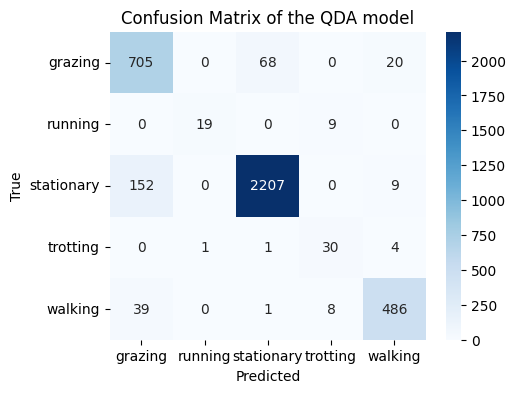

In [55]:
# Compute confusion matrix
qda_cm = confusion_matrix(y_encoded_test_inliers, y_pred_qda)

# Decode labels
class_names_qda = encoder_y.inverse_transform(list(range(qda_cm.shape[0])))

# Visualise the confusion matrix
plt.figure(figsize = (5.1, 4))
sns.heatmap(qda_cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names_qda, yticklabels = class_names_qda)
plt.title('Confusion Matrix of the QDA model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<h2 style="display: inline"> 5.4 k-Nearest Neighbours Classification </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_5_4"></a> 

In [29]:
# Determine start time
start_time = timeit.default_timer()

# Create a Memory object
memory_obj = Memory('C:/cachedir/', verbose = 0)

# Create the pipeline: scaler and classifier
# We will use a k-Nearest Neighbours Classifier
knnc_pipeline = Pipeline(
    steps=[
        ('scaler', MinMaxScaler()),
        ('classifier', KNeighborsClassifier(n_jobs = -1))
        ],
    memory=memory_obj,
    verbose=True
    )

# Set up possible values of parameters to optimize over
knnc_p_dist = {
        'scaler': [StandardScaler(), MinMaxScaler(), MaxAbsScaler(), QuantileTransformer(output_distribution = 'normal'), QuantileTransformer(output_distribution = 'uniform')],
        'classifier__n_neighbors': [2, 5, 9, 15, 20, 30],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__leaf_size': [5, 10, 20, 30, 50, 100],
        'classifier__p': [1, 2, 3]
          }

knnc_clf = RandomizedSearchCV(estimator = knnc_pipeline,
                         param_distributions = knnc_p_dist,
                         cv = inner_cv,
                         n_iter = 30,
                         n_jobs = -1,
                         verbose = 3,
                         scoring = scoring_list,
                         refit = 'balanced_accuracy')

# Run cross validation to get the scores for each metric
knnc_nested_score = cross_validate(knnc_clf, X = X_train_imp_inliers_ovrsmpl, y = y_encoded_train_inliers_ovrsmpl, cv = outer_cv, scoring = scoring_list, return_estimator = True)

# Print the best parameters for each fold of the outer cross-validation loop
for i, estimator in enumerate(knnc_nested_score['estimator']):
    print(f"Best parameters for fold {i}: {estimator.best_params_}")

# Print the best score for each fold of the outer cross-validation loop
for i, estimator in enumerate(knnc_nested_score['estimator']):
    print(f"Best score for fold {i}: {estimator.best_score_:.4f}")

# Clear the cache
memory_obj.clear()

# Determine end time
end_time = timeit.default_timer()

# Calculate and print execution time
execution_time = end_time - start_time
print(f'Executed the code in: {execution_time:.4f} seconds')

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ........ (step 2 of 2) Processing classi

Best parameters for fold 0: {'scaler': MinMaxScaler(), 'classifier__weights': 'distance', 'classifier__p': 2, 'classifier__n_neighbors': 2, 'classifier__leaf_size': 5}
Best parameters for fold 1: {'scaler': StandardScaler(), 'classifier__weights': 'distance', 'classifier__p': 3, 'classifier__n_neighbors': 2, 'classifier__leaf_size': 50}
Best parameters for fold 2: {'scaler': MinMaxScaler(), 'classifier__weights': 'distance', 'classifier__p': 2, 'classifier__n_neighbors': 2, 'classifier__leaf_size': 5}
Best parameters for fold 3: {'scaler': MaxAbsScaler(), 'classifier__weights': 'distance', 'classifier__p': 1, 'classifier__n_neighbors': 2, 'classifier__leaf_size': 30}
Best parameters for fold 4: {'scaler': QuantileTransformer(), 'classifier__weights': 'distance', 'classifier__p': 1, 'classifier__n_neighbors': 5, 'classifier__leaf_size': 5}
Best score for fold 0: 0.9791
Best score for fold 1: 0.9751
Best score for fold 2: 0.9808
Best score for fold 3: 0.9792
Best score for fold 4: 0.9791

In [49]:
# Determine start time
start_time = timeit.default_timer()

# Let us score the median/mode of the best parameters

# Fit the scaler on the training data
knnc_scaler = MinMaxScaler()
knnc_scaler.fit(X_train_imp_inliers_ovrsmpl)
# Scale the training set
X_train_imp_inliers_ovrsmpl_knnc_scaled = knnc_scaler.transform(X_train_imp_inliers_ovrsmpl)
# Scale the test dataset
X_test_imp_inliers_knnc_scaled = knnc_scaler.transform(X_test_imp_inliers)

# Declare the kNN classifier model
knnc = KNeighborsClassifier(
    weights = 'distance',
    p = 2,
    n_neighbors = 2,
    leaf_size = 5
    )

# Fit the model to the full training set
knnc.fit(X_train_imp_inliers_ovrsmpl_knnc_scaled, y_encoded_train_inliers_ovrsmpl)

# Determine end time
end_time = timeit.default_timer()

# Calculate and print execution time
execution_time = end_time - start_time
print(f'Executed the code in: {execution_time:.4f} seconds')

# Make predictions on the test set
y_pred_knnc = knnc.predict(X_test_imp_inliers_knnc_scaled)

# Compute different scoring metrics
# 'weighted' accounts for class imbalance
knnc_f1 = f1_score(y_encoded_test_inliers, y_pred_knnc, average = 'weighted')
knnc_recall = recall_score(y_encoded_test_inliers, y_pred_knnc, average = 'weighted')
knnc_accuracy = balanced_accuracy_score(y_encoded_test_inliers, y_pred_knnc)
knnc_precision = precision_score(y_encoded_test_inliers, y_pred_knnc, average = 'weighted')

print('Test set F1 score:', knnc_f1)
print('Test set Recall score:', knnc_recall)
print('Test set Accuracy score:', knnc_accuracy)
print('Test set Precision score:', knnc_precision)

Executed the code in: 0.0245 seconds
Test set F1 score: 0.927361528261372
Test set Recall score: 0.9263101888800213
Test set Accuracy score: 0.8991244073366703
Test set Precision score: 0.9298046105691026


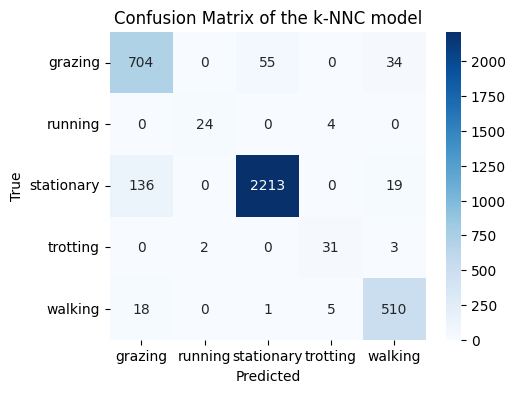

In [56]:
# Compute confusion matrix
knnc_cm = confusion_matrix(y_encoded_test_inliers, y_pred_knnc)

# Decode labels
class_names_knnc = encoder_y.inverse_transform(list(range(knnc_cm.shape[0])))

# Visualise the confusion matrix
plt.figure(figsize = (5.1, 4))
sns.heatmap(knnc_cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names_knnc, yticklabels = class_names_knnc)
plt.title('Confusion Matrix of the k-NNC model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<h2 style="display: inline"> 6. Dimensionality Reduction </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_6"></a>

<h2 style="display: inline"> 6.1 Principal Component Analysis (Linear Feature Extraction, Unsupervised) </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_6_1"></a>

In [57]:
# Create an instance of PCA
pca = PCA(n_components = 20, random_state = 0)

In [58]:
# Fit a PCA model to the scaled traning set for k-NN classification
pca.fit(X_train_imp_inliers_ovrsmpl_svc_scaled)

# Perform PCA dimensionality reduction on the scaled training set
X_train_imp_inliers_ovrsmpl_svc_scaled_pca = pca.transform(X_train_imp_inliers_ovrsmpl_svc_scaled)

# Perform PCA dimensionality reduction on the scaled test set
X_test_imp_inliers_svc_scaled_pca = pca.transform(X_test_imp_inliers_svc_scaled)

In [59]:
# Determine start time
start_time = timeit.default_timer()

# Create a Memory object
memory_obj = Memory('C:/cachedir/', verbose = 0)

# Create the pipeline: classifier, scaling is already performed
# We will use a Support Vector Classifier
svc_pipeline = Pipeline(
    steps = [
        ('classifier', SVC())
        ],
    memory = memory_obj,
    verbose = True
    )

# Set up possible values of parameters to optimize over
svc_p_dist = {
          'classifier__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
          'classifier__decision_function_shape': ['ovo', 'ovr'],
          'classifier__C': [0.01, 0.1, 1, 10, 100],
          'classifier__gamma': ['scale', 'auto'],
          'classifier__degree': [2, 3, 4],
          'classifier__shrinking': [True, False]
          }

svc_clf = RandomizedSearchCV(estimator = svc_pipeline,
                         param_distributions = svc_p_dist,
                         cv = inner_cv,
                         n_iter = 30,
                         n_jobs = -1,
                         verbose = 3,
                         scoring = scoring_list,
                         refit = 'balanced_accuracy')

# Run cross validation to get the scores for each metric
svc_nested_score = cross_validate(svc_clf, X = X_train_imp_inliers_ovrsmpl_svc_scaled_pca, y = y_encoded_train_inliers_ovrsmpl, cv = outer_cv, scoring = scoring_list, return_estimator = True)

# Print the best parameters for each fold of the outer cross-validation loop
for i, estimator in enumerate(svc_nested_score['estimator']):
    print(f"Best parameters for fold {i}: {estimator.best_params_}")

# Print the best score for each fold of the outer cross-validation loop
for i, estimator in enumerate(svc_nested_score['estimator']):
    print(f"Best score for fold {i}: {estimator.best_score_:.4f}")

# Clear the cache
memory_obj.clear()

# Determine end time
end_time = timeit.default_timer()

# Calculate and print execution time
execution_time = end_time - start_time
print(f'Nested cross-validation was perfomed in {execution_time:.4f} seconds')

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ........ (step 1 of 1) Processing classifier, total=   5.1s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ........ (step 1 of 1) Processing classifier, total=   1.8s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ........ (step 1 of 1) Processing classifier, total=   5.0s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ........ (step 1 of 1) Processing classifier, total=   2.4s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ........ (step 1 of 1) Processing classifier, total=   2.6s


Best parameters for fold 0: {'classifier__shrinking': False, 'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__degree': 3, 'classifier__decision_function_shape': 'ovo', 'classifier__C': 100}
Best parameters for fold 1: {'classifier__shrinking': True, 'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__degree': 3, 'classifier__decision_function_shape': 'ovr', 'classifier__C': 10}
Best parameters for fold 2: {'classifier__shrinking': False, 'classifier__kernel': 'rbf', 'classifier__gamma': 'auto', 'classifier__degree': 2, 'classifier__decision_function_shape': 'ovo', 'classifier__C': 100}
Best parameters for fold 3: {'classifier__shrinking': False, 'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__degree': 4, 'classifier__decision_function_shape': 'ovr', 'classifier__C': 10}
Best parameters for fold 4: {'classifier__shrinking': True, 'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__degree': 4, 'classif

In [60]:
# Determine start time
start_time = timeit.default_timer()

# Let us score the median/mode of the best parameters, train on training data and score on test data

# Declare the SVC model
svc = SVC(
    kernel = 'rbf',
    degree = 3,
    gamma = 'scale',
    decision_function_shape = 'ovo',
    C = 100,
    shrinking = False,
    verbose = True
    )

# Fit the model to the full training set
svc.fit(X_train_imp_inliers_ovrsmpl_svc_scaled_pca, y_encoded_train_inliers_ovrsmpl)

# Determine end time
end_time = timeit.default_timer()

# Calculate and print execution time
execution_time = end_time - start_time
print(f'The model was trained in {execution_time:.4f} seconds')

# Make predictions on the scaled test set
y_pred_svc = svc.predict(X_test_imp_inliers_svc_scaled_pca)

# Compute different scoring metrics
# 'weighted' accounts for class imbalance
svc_f1 = f1_score(y_encoded_test_inliers, y_pred_svc, average = 'weighted')
svc_recall = recall_score(y_encoded_test_inliers, y_pred_svc, average = 'weighted')
svc_accuracy = balanced_accuracy_score(y_encoded_test_inliers, y_pred_svc)
svc_precision = precision_score(y_encoded_test_inliers, y_pred_svc, average = 'weighted')

print('Test set F1 score:', svc_f1)
print('Test set Recall score:', svc_recall)
print('Test set Accuracy score:', svc_accuracy)
print('Test set Precision score:', svc_precision)

[LibSVM]The model was trained in 8.6118 seconds
Test set F1 score: 0.9275771630434769
Test set Recall score: 0.9271082734769885
Test set Accuracy score: 0.8771425603081987
Test set Precision score: 0.9283398111246366


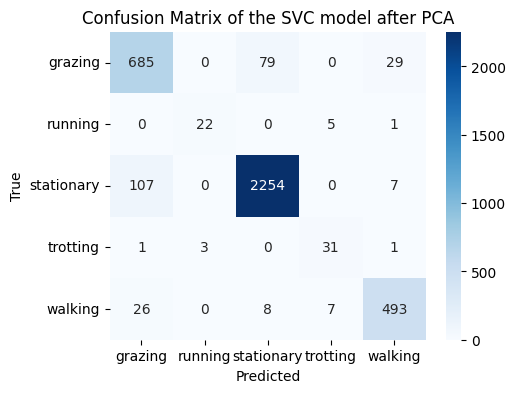

In [61]:
# Compute confusion matrix
svc_cm = confusion_matrix(y_encoded_test_inliers, y_pred_svc)

# Decode labels
class_names_svc = encoder_y.inverse_transform(list(range(svc_cm.shape[0])))

# Visualise the confusion matrix
plt.figure(figsize = (5.1, 4))
sns.heatmap(svc_cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names_svc, yticklabels = class_names_svc)
plt.title('Confusion Matrix of the SVC model after PCA')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<h2 style="display: inline"> 6.2 Linear Discriminant Analysis (Linear Feature Extraction, Supervised) </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_6_2"></a>

In [63]:
# Create an instance of LDA
# The number of generated features will be min(classes-1, number of features), 4 in our case
lda = LinearDiscriminantAnalysis()

In [64]:
# Fit a PCA model to the scaled traning set for k-NN classification
lda.fit(X_train_imp_inliers_ovrsmpl_svc_scaled, y_encoded_train_inliers_ovrsmpl)

# Perform PCA dimensionality reduction on the scaled training set
X_train_imp_inliers_ovrsmpl_svc_scaled_lda = lda.transform(X_train_imp_inliers_ovrsmpl_svc_scaled)

# Perform PCA dimensionality reduction on the scaled test set
X_test_imp_inliers_svc_scaled_lda = lda.transform(X_test_imp_inliers_svc_scaled)

In [65]:
# Determine start time
start_time = timeit.default_timer()

# Create a Memory object
memory_obj = Memory('C:/cachedir/', verbose = 0)

# Create the pipeline: classifier, scaling is already performed
# We will use a Support Vector Classifier
svc_pipeline = Pipeline(
    steps = [
        ('classifier', SVC())
        ],
    memory = memory_obj,
    verbose = True
    )

# Set up possible values of parameters to optimize over
svc_p_dist = {
          'classifier__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
          'classifier__decision_function_shape': ['ovo', 'ovr'],
          'classifier__C': [0.01, 0.1, 1, 10, 100],
          'classifier__gamma': ['scale', 'auto'],
          'classifier__degree': [2, 3, 4],
          'classifier__shrinking': [True, False]
          }

svc_clf = RandomizedSearchCV(estimator = svc_pipeline,
                         param_distributions = svc_p_dist,
                         cv = inner_cv,
                         n_iter = 30,
                         n_jobs = -1,
                         verbose = 3,
                         scoring = scoring_list,
                         refit = 'balanced_accuracy')

# Run cross validation to get the scores for each metric
svc_nested_score = cross_validate(svc_clf, X = X_train_imp_inliers_ovrsmpl_svc_scaled_lda, y = y_encoded_train_inliers_ovrsmpl, cv = outer_cv, scoring = scoring_list, return_estimator = True)

# Print the best parameters for each fold of the outer cross-validation loop
for i, estimator in enumerate(svc_nested_score['estimator']):
    print(f"Best parameters for fold {i}: {estimator.best_params_}")

# Print the best score for each fold of the outer cross-validation loop
for i, estimator in enumerate(svc_nested_score['estimator']):
    print(f"Best score for fold {i}: {estimator.best_score_:.4f}")

# Clear the cache
memory_obj.clear()

# Determine end time
end_time = timeit.default_timer()

# Calculate and print execution time
execution_time = end_time - start_time
print(f'Nested cross-validation was perfomed in {execution_time:.4f} seconds')

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ........ (step 1 of 1) Processing classifier, total=   4.4s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ........ (step 1 of 1) Processing classifier, total=   4.2s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ........ (step 1 of 1) Processing classifier, total=  18.7s
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Pipeline] ........ (step 1 of 1) Processing classifier, total=   2.6s
Fitting 4 folds for each of 30 candidates, totalling 120 fits


In [ ]:
# Determine start time
start_time = timeit.default_timer()

# Let us score the median/mode of the best parameters, train on training data and score on test data

# Declare the SVC model
svc = SVC(
    kernel = 'rbf',
    degree = 3,
    gamma = 'auto',
    decision_function_shape = 'ovo',
    C = 100,
    shrinking = True,
    verbose = True
    )

# Fit the model to the full training set
svc.fit(X_train_imp_inliers_ovrsmpl_svc_scaled_lda, y_encoded_train_inliers_ovrsmpl)

# Determine end time
end_time = timeit.default_timer()

# Calculate and print execution time
execution_time = end_time - start_time
print(f'The model was trained in {execution_time:.4f} seconds')

# Make predictions on the scaled test set
y_pred_svc = svc.predict(X_test_imp_inliers_svc_scaled_lda)

# Compute different scoring metrics
# 'weighted' accounts for class imbalance
svc_f1 = f1_score(y_encoded_test_inliers, y_pred_svc, average = 'weighted')
svc_recall = recall_score(y_encoded_test_inliers, y_pred_svc, average = 'weighted')
svc_accuracy = balanced_accuracy_score(y_encoded_test_inliers, y_pred_svc)
svc_precision = precision_score(y_encoded_test_inliers, y_pred_svc, average = 'weighted')

print('Test set F1 score:', svc_f1)
print('Test set Recall score:', svc_recall)
print('Test set Accuracy score:', svc_accuracy)
print('Test set Precision score:', svc_precision)

In [ ]:
# Compute confusion matrix
svc_cm = confusion_matrix(y_encoded_test_inliers, y_pred_svc)

# Decode labels
class_names_svc = encoder_y.inverse_transform(list(range(svc_cm.shape[0])))

# Visualise the confusion matrix
plt.figure(figsize = (5.1, 4))
sns.heatmap(svc_cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names_svc, yticklabels = class_names_svc)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<h2 style="display: inline"> 6.3 Locally Linear Embedding (Non-Linear Feature Extraction, Unsupervised) </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_6_3"></a>

In [47]:
# Create an instance of LLE
lle = LocallyLinearEmbedding(n_components=20)

In [ ]:
# Fit a PCA model to the scaled traning set for k-NN classification
lle.fit(X_train_imp_inliers_ovrsmpl_svc_scaled)

# Perform PCA dimensionality reduction on the scaled training set
X_train_imp_inliers_ovrsmpl_svc_scaled_lle = lle.transform(X_train_imp_inliers_ovrsmpl_svc_scaled)

# Perform PCA dimensionality reduction on the scaled test set
X_test_imp_inliers_svc_scaled_lle = lle.transform(X_test_imp_inliers_svc_scaled)

In [ ]:
# Determine start time
start_time = timeit.default_timer()

# Create a Memory object
memory_obj = Memory('C:/cachedir/', verbose = 0)

# Create the pipeline: classifier, scaling is already performed
# We will use a Support Vector Classifier
svc_pipeline = Pipeline(
    steps = [
        ('classifier', SVC())
        ],
    memory = memory_obj,
    verbose = True
    )

# Set up possible values of parameters to optimize over
svc_p_dist = {
          'classifier__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
          'classifier__decision_function_shape': ['ovo', 'ovr'],
          'classifier__C': [0.01, 0.1, 1, 10, 100],
          'classifier__gamma': ['scale', 'auto'],
          'classifier__degree': [2, 3, 4],
          'classifier__shrinking': [True, False]
          }

svc_clf = RandomizedSearchCV(estimator = svc_pipeline,
                         param_distributions = svc_p_dist,
                         cv = inner_cv,
                         n_iter = 30,
                         n_jobs = -1,
                         verbose = 3,
                         scoring = scoring_list,
                         refit = 'balanced_accuracy')

# Run cross validation to get the scores for each metric
svc_nested_score = cross_validate(svc_clf, X = X_train_imp_inliers_ovrsmpl_svc_scaled_lle, y = y_encoded_train_inliers_ovrsmpl, cv = outer_cv, scoring = scoring_list, return_estimator = True)

# Print the best parameters for each fold of the outer cross-validation loop
for i, estimator in enumerate(svc_nested_score['estimator']):
    print(f"Best parameters for fold {i}: {estimator.best_params_}")

# Print the best score for each fold of the outer cross-validation loop
for i, estimator in enumerate(svc_nested_score['estimator']):
    print(f"Best score for fold {i}: {estimator.best_score_:.4f}")

# Clear the cache
memory_obj.clear()

# Determine end time
end_time = timeit.default_timer()

# Calculate and print execution time
execution_time = end_time - start_time
print(f'Nested cross-validation was perfomed in {execution_time:.4f} seconds')

In [ ]:
# Determine start time
start_time = timeit.default_timer()

# Let us score the median/mode of the best parameters, train on training data and score on test data

# Declare the SVC model
svc = SVC(
    kernel = 'rbf',
    degree = 3,
    gamma = 'auto',
    decision_function_shape = 'ovo',
    C = 100,
    shrinking = True,
    verbose = True
    )

# Fit the model to the full training set
svc.fit(X_train_imp_inliers_ovrsmpl_svc_scaled_lle, y_encoded_train_inliers_ovrsmpl)

# Determine end time
end_time = timeit.default_timer()

# Calculate and print execution time
execution_time = end_time - start_time
print(f'The model was trained in {execution_time:.4f} seconds')

# Make predictions on the scaled test set
y_pred_svc = svc.predict(X_test_imp_inliers_svc_scaled_lle)

# Compute different scoring metrics
# 'weighted' accounts for class imbalance
svc_f1 = f1_score(y_encoded_test_inliers, y_pred_svc, average = 'weighted')
svc_recall = recall_score(y_encoded_test_inliers, y_pred_svc, average = 'weighted')
svc_accuracy = balanced_accuracy_score(y_encoded_test_inliers, y_pred_svc)
svc_precision = precision_score(y_encoded_test_inliers, y_pred_svc, average = 'weighted')

print('Test set F1 score:', svc_f1)
print('Test set Recall score:', svc_recall)
print('Test set Accuracy score:', svc_accuracy)
print('Test set Precision score:', svc_precision)